In [2]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import plancklens
from plancklens import utils
from plancklens import nhl
from plancklens.n1 import n1
from plancklens import qest, qecl, qresp
import orphics
from orphics import maps, cosmology
import pandas as pd

import symlens as s
import pixell
from pixell import enmap, curvedsky

In [27]:
theory = cosmology.default_theory()
ells = np.arange(0, 6001, 1)
clee = theory.lCl('EE', ells)
clbb = theory.lCl('BB', ells)
clpp_fid =  utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))['pp']

In [26]:
class bin1D(object):
    def __init__(self, ls, bin_edges):
        self.centers = (bin_edges[1:]+bin_edges[:-1])/2.
        self.digitized = np.digitize(ls, bin_edges,right=True)
        self.bin_edges = bin_edges
    def bin(self,data1d,weights=None):
        if weights is None:
            res = np.bincount(self.digitized,(data1d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]
        else:
            res = np.bincount(self.digitized,(data1d*weights).reshape(-1))[1:-1]/np.bincount(self.digitized,weights.reshape(-1))[1:-1]
        return self.centers,res

In [5]:
def binave(map, modlmap, ellmin, ellmax, delta_l):
    bin_edges = np.arange(ellmin, ellmax+delta_l+1, delta_l)
    binner = s.utils.bin2D(modlmap, bin_edges)

    centers, p1d = binner.bin(map)
    return centers, p1d

In [65]:
exps_config = {
    'CMB_S3': {
        'nlev_t': 7,
        'nlev_p': 7*2**0.5,
        'beam_arcmin': 1.4
    },
    'CMB_S4': {
        'nlev_t': 1,
        'nlev_p':2**0.5,
        'beam_arcmin': 3
    }
}

exps_config = {
    'CMB_S4': {
        'nlev_t': 1,
        'nlev_p':2**0.5,
        'beam_arcmin': 1.4
    }
}

moments = {'moments1':{'ellmin':30, 'ellmax':3000, 'delta_L':150},\
           'moments2':{'ellmin':30, 'ellmax':4000, 'delta_L':200}}
ellmin = 30
ls = np.arange(0, 6001)

In [7]:
cls_path = os.path.join(os.path.dirname(os.path.abspath(plancklens.__file__)), 'data', 'cls')

In [8]:
ellmaxs = [3000]
ellmin_plot = 21
ellmax_plot = 3000
ells_plot = np.arange(0, ellmax_plot+1)

bin_edge = np.arange(ellmin_plot, ellmax_plot, 20)
print(bin_edge)

[  21   41   61   81  101  121  141  161  181  201  221  241  261  281
  301  321  341  361  381  401  421  441  461  481  501  521  541  561
  581  601  621  641  661  681  701  721  741  761  781  801  821  841
  861  881  901  921  941  961  981 1001 1021 1041 1061 1081 1101 1121
 1141 1161 1181 1201 1221 1241 1261 1281 1301 1321 1341 1361 1381 1401
 1421 1441 1461 1481 1501 1521 1541 1561 1581 1601 1621 1641 1661 1681
 1701 1721 1741 1761 1781 1801 1821 1841 1861 1881 1901 1921 1941 1961
 1981 2001 2021 2041 2061 2081 2101 2121 2141 2161 2181 2201 2221 2241
 2261 2281 2301 2321 2341 2361 2381 2401 2421 2441 2461 2481 2501 2521
 2541 2561 2581 2601 2621 2641 2661 2681 2701 2721 2741 2761 2781 2801
 2821 2841 2861 2881 2901 2921 2941 2961 2981]


In [9]:
shape, wcs = enmap.fullsky_geometry(res=4*pixell.utils.arcmin)

In [10]:
for exp, param in exps_config.items():
    for ellmax in ellmaxs:
        feed_dict = {}
        map_modlmap = enmap.modlmap(shape, wcs)
        kbeam = s.utils.gauss_beam(map_modlmap, param['beam_arcmin'])
        n2d = (param['nlev_p']*np.pi/180./60.)**2./kbeam**2.
        
        feed_dict['uC_E_E'] = s.utils.interp(ells, clee)(map_modlmap)
        feed_dict['tC_E_E'] = feed_dict['uC_E_E'] + n2d
        feed_dict['tC_B_B'] = n2d
        
        cmask = s.utils.mask_kspace(shape, wcs, lmin=ellmin, lmax=ellmax)
        kmask = s.utils.mask_kspace(shape, wcs, lmin=ellmin, lmax=ellmax)
        
        norm_k_eb = s.A_l(shape,
                       wcs,
                       feed_dict,
                       "hu_ok",
                       'EB',
                       xmask=cmask,
                       ymask=cmask,
                       kmask=kmask)


In [11]:
for exp, param in exps_config.items():
    for ellmax in ellmaxs:
        feed_dict = {}
        map_modlmap = enmap.modlmap(shape, wcs)
        kbeam = s.utils.gauss_beam(map_modlmap, param['beam_arcmin'])
        n2d = (param['nlev_t']*np.pi/180./60.)**2./kbeam**2.
        
        feed_dict['uC_T_T'] = s.utils.interp(ells, clee)(map_modlmap)
        feed_dict['tC_T_T'] = feed_dict['uC_T_T'] + n2d
        
        cmask = s.utils.mask_kspace(shape, wcs, lmin=ellmin, lmax=ellmax)
        kmask = s.utils.mask_kspace(shape, wcs, lmin=ellmin, lmax=ellmax)
        
        norm_k_tt = s.A_l(shape,
                       wcs,
                       feed_dict,
                       "hu_ok",
                       'TT',
                       xmask=cmask,
                       ymask=cmask,
                       kmask=kmask)        

In [103]:
Ls, norm_tt = binave(norm_k_tt, map_modlmap, ellmin+0.5, ellmax-1, 1)
Ls, norm_eb = binave(norm_k_eb, map_modlmap, ellmin+0.5, ellmax-1, 1)

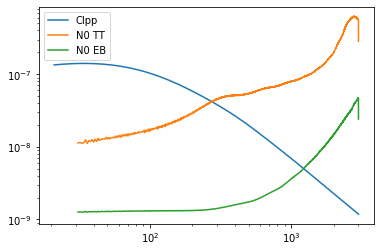

In [175]:
factor_L = Ls**2*(Ls+1)**2/(2*np.pi)
factor = ls**2*(ls+1)**2/(2*np.pi)

plt.plot(ls[ellmin_plot:ellmax_plot], (factor*clpp_fid[ls])[ellmin_plot:ellmax_plot], label='Clpp')
plt.plot(Ls, factor_L*norm_tt/Ls**2, label='N0 TT')
plt.plot(Ls, factor_L*norm_eb/Ls**2, label='N0 EB')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [176]:
cl_unl = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
cl_len = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))

In [177]:
# transf = hp.gauss_beam(5. / 60. / 180. * np.pi, lmax=lmax_ivf) * hp.pixwin(nside)[:lmax_ivf + 1]
# transf = hp.gauss_beam(5. / 60. / 180. * np.pi, lmax=lmax_qlm) * maps.gauss_beam(ls, beam_arcmin)
ells = np.arange(0, ellmax+1)
transf = hp.gauss_beam(5. / 60. / 180. * np.pi, lmax=ellmax) * maps.gauss_beam(ells, param['beam_arcmin'])

In [178]:
ftl = utils.cli(cl_len['tt'][:ellmax + 1] + (param['nlev_t'] / 60. / 180. * np.pi / transf) ** 2)
fel = utils.cli(cl_len['ee'][:ellmax + 1] + (param['nlev_p'] / 60. / 180. * np.pi / transf) ** 2)
fbl = utils.cli(cl_len['bb'][:ellmax + 1] + (param['nlev_p'] / 60. / 180. * np.pi / transf) ** 2)
ftl[:ellmin] *= 0.
fel[:ellmin] *= 0.
fbl[:ellmin] *= 0.

In [179]:
libdir_n1_dd = '.'
# normalize n1
cl_weight = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
cl_weight['bb'] *= 0.

cl_weight = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
cl_weight['bb'] *= 0.

qresp_dd = qresp.resp_lib_simple(libdir_n1_dd, ellmax, cl_weight, cl_len,\
                     {'t': ftl, 'e': fel, 'b': fbl}, ellmax)
qc_resp_tt = qresp_dd.get_response('ptt', 'p')**2
qc_resp_eb = qresp_dd.get_response('p_eb', 'p')**2

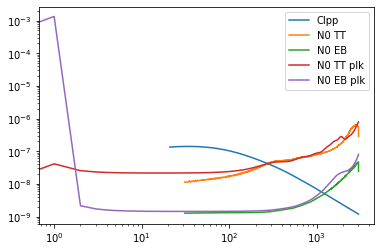

In [210]:
plt.plot(ls[ellmin_plot:ellmax_plot], (factor*clpp_fid[ls])[ellmin_plot:ellmax_plot], label='Clpp')
plt.plot(Ls, factor_L*norm_tt/Ls**2, label='N0 TT')
plt.plot(Ls, factor_L*norm_eb/Ls**2, label='N0 EB')

factor_ells = ells**2*(ells+1)**2/(2*np.pi)**2
plt.plot(ells, factor_ells*utils.cli(qresp_dd.get_response('ptt', 'p')[ells]), label='N0 TT plk')
plt.plot(ells, factor_ells*utils.cli(qresp_dd.get_response('p_eb', 'p')[ells]), label='N0 EB plk')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [199]:
#---- N1 lensing bias library:
n1_dd = n1.library_n1(libdir_n1_dd,cl_len['tt'],cl_len['te'],cl_len['ee'])

In [200]:
claa_07 = np.loadtxt('../inputPs/claa_A1e-07.txt')[:,1]
claa_05 = np.loadtxt('../inputPs/claa_A1e-05.txt')[:,1]
claa_06 = np.loadtxt('../inputPs/claa_A1e-06.txt')[:,1]
# claa_08 = np.loadtxt('../inputPs/claa_A1e-08.txt')[:,1]

In [201]:
# n1aa_05 = n1_dd.get_n1('reb', 'p', claa_05, ftl, fel, fbl, lmax_ivf-1)
# n1aa_06 = n1_dd.get_n1('reb', 'p', claa_06, ftl, fel, fbl, lmax_ivf-1)
# n1pp_tt = n1_dd.get_n1('ptt', 'p', clpp_fid, ftl, fel, fbl, lmax_ivf-1)
# n1pp_eb = n1_dd.get_n1('peb', 'p', clpp_fid, ftl, fel, fbl, lmax_ivf-1)

In [202]:
# n1aa_06 = n1_dd.get_n1('peb', 'r', claa_06, ftl, fel, fbl, lmax_ivf-1)
n1aa_07 = n1_dd.get_n1('peb', 'r', claa_07, ftl, fel, fbl, ellmax)

In [203]:
# n1pp_tt_n = utils.cli(qc_resp_tt)[:lmax_ivf]*n1pp_tt
# n1pp_eb_n = utils.cli(qc_resp_eb)[:lmax_ivf]*n1pp_eb
# n1aa_06_n = utils.cli(qc_resp_eb)[:lmax_ivf]*n1aa_06
# n1aa_07_n = utils.cli(qc_resp_eb)[:ellmax+1]*n1aa_07
n1aa_07_n = ((norm_eb*2*np.pi)/Ls**2)**2*n1aa_07[31:]

In [204]:
# plt.plot(Ls[Lmin:lmax_ivf], (factor*clpp_fid[:lmax_ivf])[Lmin:lmax_ivf])
# plt.plot(Ls[Lmin:lmax_ivf], (factor*n1pp_tt_n)[Lmin:lmax_ivf], label='n1tt')
# plt.plot(Ls[Lmin:lmax_ivf], (factor*n1pp_eb_n)[Lmin:lmax_ivf], label='n1eb')
# plt.plot(Ls[Lmin:lmax_ivf], abs((factor*n1aa_07_n)[Lmin:lmax_ivf]), label='n1eb aa')

# plt.xscale('log')
# plt.yscale('log')
# plt.legend()

In [205]:
data = pd.read_csv('./CMB_S4_30_3000_n.csv')
bias = ((data['EB_rot_reckap_x_reckap']-data['EB_reckap_x_reckap'])-(data['EB_rot_rdn0']-data['EB_rdn0']))/\
                 data['EB_inkap_x_inkap']

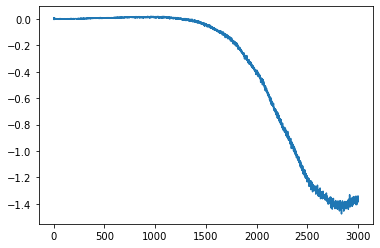

In [206]:
plt.plot(bias)

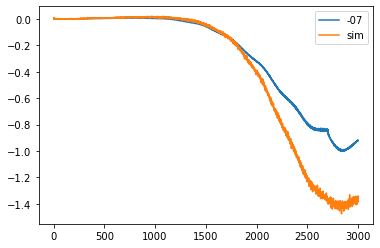

In [222]:
plt.plot(Ls[:-1], 100*n1aa_07_n[:-1]/clpp_fid[31:3000], label='-07')
# plt.plot(-norm_eb/Ls**2/clpp_fid[31:3001], label='N0/clpp')
plt.plot(bias, label='sim')
# plt.plot(Ls[Lmin:lmax_ivf], (n1aa_06_n[:lmax_ivf]/clpp_fid[:lmax_ivf])[Lmin:lmax_ivf], label='-06')
plt.legend()